In [11]:
import os
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS, Transformer

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt

In [12]:
def extract_coordinates_with_data(folder_path):
    """
    Iterates over all .tif files in folder_path, extracting coordinates and corresponding valid_data values.
    Returns a dictionary where each key is a filename, and the value is a DataFrame with coordinates and data values.
    
    :param folder_path: Path to the folder containing .tif files
    :return: Dictionary {filename: DataFrame(columns=['Longitude', 'Latitude', 'Value'])}
    """
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.tif')]
    if not tif_files:
        print(f"❌ No .tif files found in: {folder_path}")
        return {}
    
    tif_files.sort()
    results = {}
    
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        print(f"\n📂 Processing: {tif_path}")
        
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1)  # Read first band
                transform = src.transform  # Get affine transformation
                
                # Apply NoData mask if defined
                if src.nodata is not None:
                    data = np.ma.masked_array(data, mask=(data == src.nodata))
                
                rows, cols = data.shape
                coords = []
                values = []
                
                for row in range(rows):
                    for col in range(cols):
                        if not np.ma.is_masked(data[row, col]):  # Consider only valid values
                            lon, lat = rasterio.transform.xy(transform, row, col)
                            coords.append((lon, lat))
                            values.append(data[row, col])
                
                # Create DataFrame
                df = pd.DataFrame(coords, columns=['Longitude', 'Latitude'])
                df['Value'] = values
                results[tif_file] = df
                
        except Exception as e:
            print(f"❌ Error processing {tif_file}: {e}")
    
    return results

In [13]:
folder_path = '/Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data'

In [14]:
dictionary = extract_coordinates_with_data(folder_path)


📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2011LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2012LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2013LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2014LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2015LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2016LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2017LCT.tif

📂 Processing: /

In [15]:
value = dictionary["2010LCT.tif"]

# Convert the value (a list of lists) into a DataFrame
dfprovaprova = pd.DataFrame(value, columns=["Longitude", "Latitude", "Value"])
dfprovaprova['coordinate'] = list(zip(dfprovaprova['Longitude'], dfprovaprova['Latitude']))
coordinates_parte2 = dfprovaprova['coordinate'].tolist()

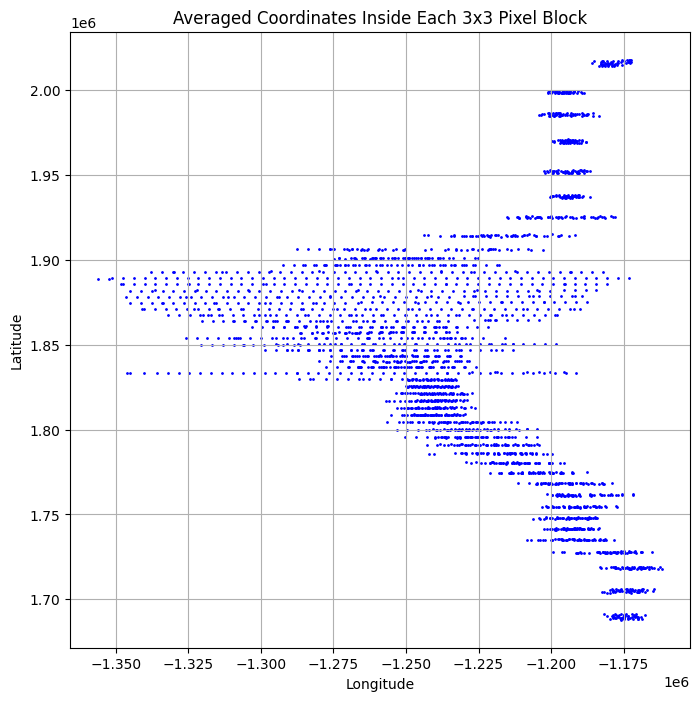

Number of averaged coordinates: 2704


In [12]:
def average_coordinates(coordinates, grid_size=8):
    """
    Averages coordinates in grid blocks (3x3).
    
    Args:
    - coordinates: List of tuples (x, y) representing coordinates.
    - grid_size: The grid size for averaging, default is 3 (for 3x3 block).
    
    Returns:
    - List of tuples containing averaged coordinates for each 3x3 block.
    """
    averaged_coords = []
    
    # We assume coordinates are sorted in the same way as a raster
    num_rows = int(np.sqrt(len(coordinates)))  # Assuming square raster (rows == cols)
    
    for row in range(0, num_rows, grid_size):
        for col in range(0, num_rows, grid_size):
            # Get the coordinates within the 3x3 block
            block_coords = []
            
            for i in range(grid_size):
                for j in range(grid_size):
                    idx = (row + i) * num_rows + (col + j)  # Index in the flat list of coordinates
                    if idx < len(coordinates):  # Ensure it's within bounds
                        block_coords.append(coordinates[idx])
            
            # Calculate the average of x and y in the block
            if block_coords:
                avg_x = np.mean([coord[0] for coord in block_coords])
                avg_y = np.mean([coord[1] for coord in block_coords])
                averaged_coords.append((avg_x, avg_y))
    
    return averaged_coords


# Step 3: Average coordinates in 3x3 blocks
averaged_coordinates_2 = average_coordinates(coordinates_parte2)

# Step 4: Plot the averaged coordinates using Matplotlib
x_coords, y_coords = zip(*averaged_coordinates_2)  # Unzip the averaged coordinates into two separate lists

# Create a scatter plot of the averaged coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', s=1)  # s=1 sets the marker size to 1
plt.title("Averaged Coordinates Inside Each 3x3 Pixel Block")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Optionally, print the number of averaged coordinates
print(f"Number of averaged coordinates: {len(averaged_coordinates_2)}")

In [51]:
def average_coordinates_with_value(coordinates, values, grid_size=20):
    """
    Averages coordinates in grid blocks (grid_size x grid_size) and assigns the corresponding 'Value'
    to each averaged coordinate.
    
    Args:
    - coordinates: List of tuples (x, y) representing coordinates.
    - values: List of 'Value' corresponding to the coordinates.
    - grid_size: The grid size for averaging, default is 20 (for 20x20 block).
    
    Returns:
    - A DataFrame containing the averaged coordinates and their corresponding 'Value'.
    """
    averaged_coords = []
    averaged_values = []
    
    # We assume coordinates are sorted in the same way as a raster
    num_rows = int(np.sqrt(len(coordinates)))  # Assuming square raster (rows == cols)
    
    for row in range(0, num_rows, grid_size):
        for col in range(0, num_rows, grid_size):
            # Get the coordinates within the grid block
            block_coords = []
            block_values = []
            
            for i in range(grid_size):
                for j in range(grid_size):
                    idx = (row + i) * num_rows + (col + j)  # Index in the flat list of coordinates
                    if idx < len(coordinates):  # Ensure it's within bounds
                        block_coords.append(coordinates[idx])
                        block_values.append(values[idx])
            
            # Calculate the average of x and y in the block
            if block_coords:
                avg_x = np.mean([coord[0] for coord in block_coords])
                avg_y = np.mean([coord[1] for coord in block_coords])
                
                # Find the closest original coordinate to the averaged coordinate
                tree = cKDTree(block_coords)
                dist, idx = tree.query((avg_x, avg_y))  # Get the closest original coordinate
                
                # Append the averaged coordinate and its corresponding 'Value'
                averaged_coords.append((avg_x, avg_y))
                averaged_values.append(block_values[idx])
    
    # Return the DataFrame with averaged coordinates and corresponding 'Value'
    df_averaged = pd.DataFrame(averaged_coords, columns=['longitude', 'latitude'])
    df_averaged['Value'] = averaged_values
    
    return df_averaged

In [17]:
def transform_coordinates(x, y):
    """
    Transforms coordinates from the Sinusoidal projection to WGS 84 (Latitude/Longitude).
    
    :param x: Easting (X-coordinate) in Sinusoidal projection
    :param y: Northing (Y-coordinate) in Sinusoidal projection
    :return: A tuple containing the latitude and longitude in WGS 84
    """
    # Define the Sinusoidal projection based on the PROJ4 parameters
    src_crs = CRS.from_proj4('+proj=sinu +a=6371007.181 +b=6371007.181 +units=m')

    # Define the target CRS for WGS 84 (Latitude/Longitude)
    dst_crs = CRS("EPSG:4326")  # WGS 84 (Latitude/Longitude)

    # Create a transformer object to convert between CRS
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)

    # Convert the given coordinates from Sinusoidal to Latitude/Longitude
    lon, lat = transformer.transform(x, y)

    return lat, lon

In [52]:
averaged_df = average_coordinates_with_value(dfprovaprova['coordinate'].tolist(), dfprovaprova['Value'].tolist(), grid_size=8)
averaged_df[['newlong','newlat']] = averaged_df.apply(
    lambda row: pd.Series(transform_coordinates(row['latitude'], row['longitude'])), axis=1
)

In [37]:
averaged_df['newlat'] = averaged_df['newlat'].round(5)
averaged_df['newlong'] = averaged_df['newlong'].round(5)

In [ ]:
averaged_df

Now I have to export this file and create the structure to plot it following what the video said 

In [1]:
averaged_df.to_pickle("averaged.pkl")

NameError: name 'averaged_df' is not defined

----

In [19]:
import pandas as pd

In [ ]:
#df = pd.read_pickle("averaged.pkl")

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
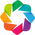

In [20]:
# plot wtih holoviews + datashader - bokeh with map background
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from bokeh.io import push_notebook, show, output_notebook
output_notebook()
hv.extension('bokeh')

%opts Overlay [width=800 height=600 toolbar='above' xaxis=None yaxis=None]
%opts QuadMesh [tools=['hover'] colorbar=True] (alpha=0 hover_alpha=0.2)

T = 0.05
PX = 1

def plot_map(data, label, agg_data, agg_name, cmap):
    url="http://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{Z}/{Y}/{X}.png"
    geomap = gv.WMTS(url)
    points = hv.Points(gv.Dataset(data, kdims=['x', 'y'], vdims=[agg_name]))
    agg = datashade(points, element_type=gv.Image, aggregator=agg_data, cmap=cmap)
    zip_codes = dynspread(agg, threshold=T, max_px=PX)
    hover = hv.util.Dynamic(rasterize(points, aggregator=agg_data, width=50, height=25, streams=[RangeXY]), operation=hv.QuadMesh)
    hover = hover.options(cmap=cmap)
    img = geomap * zip_codes * hover
    img = img.relabel(label)
    return img

In [7]:
averaged_df = df

In [29]:
from datashader.utils import lnglat_to_meters as webm
x, y = webm(averaged_df.newlong, averaged_df.newlat)
averaged_df['x'] = pd.Series(x)
averaged_df['y'] = pd.Series(y)

agg_name = 'Value'
label  = 'Desertafrication'
data = averaged_df
agg_data = ds.mean(agg_name)
cmap = fire

In [30]:
plot_map(data, label, agg_data, agg_name, cmap)

BokehModel(combine_events=True, render_bundle={'docs_json': {'f80d5764-dd1e-4560-887b-c51ce1d2fa0b': {'version…

-----

In [53]:
df = pd.read_pickle("final_df.pkl")

In [54]:
import folium
import pandas as pd
import geopandas
from shapely.geometry import Point

‣ OpenStreetMap
‣ Mapbox Bright
‣ Mapbox Control Room
‣ Stamen Terrain
‣ Stamen Toner
‣ Stamen Watercolor
‣ CartoDB positron
‣ CartoDB dark_matter

In [55]:
center = [16.75, -11.5]
zoom_start=10

m_type_1 = "cartodbdark_matter"
m_type_2 = "cartodbpositron"
m_type_3 = "OpenStreetMap"

m = folium.Map(location=center, zoom_start=zoom_start, tiles=m_type_3)
m

In [56]:
def init_map(center=center, zoom_start=10, map_type="cartodbpositron"):
    return folium.Map(location=center, zoom_start=zoom_start, tiles=map_type)

init_map()

In [61]:
def create_point_map(df):

    df['coordinate'] = df['coordinate'].apply(Point)
    df = geopandas.GeoDataFrame(df, geometry='coordinate')
    df = df.dropna(subset=['Latitude', 'Longitude', 'coordinate'])
    return df

import folium


import folium

def color_for_value(value):
    """
    Returns a color based on the value.
    7 -> dark green
    10 -> light green
    16 -> yellow
    """
    if value == 7:
        return 'darkgreen'
    elif value == 10:
        return 'lightgreen'
    elif value == 16:
        return 'yellow'
    else:
        return 'gray'  # Default color if no match is found


def plot_from_df(df, folium_map):
    # Ensure that 'value2010' exists in the DataFrame
    if 'value2010' not in df.columns:
        raise ValueError("The DataFrame must contain a 'value2010' column.")
    
    # Loop through each row in the DataFrame
    for i, row in df.iterrows():
        # Set the marker's location using latitude and longitude
        location = [row.Latitude, row.Longitude]
        
        # Create a tooltip that shows the 'Value' column from the DataFrame
        tooltip = f"value2010: {row['value2010']}"
        
        # Get the color for the current value
        color = color_for_value(row['value2010'])
        
        # Create a small square with the chosen color using a DivIcon
        icon = folium.DivIcon(
            html=f'<div style="width: 10px; height: 10px; background-color: {color}; border-radius: 2px;"></div>'
        )
        
        # Create a marker with the custom icon and the tooltip
        folium.Marker(
            location,
            tooltip=tooltip,  # Display the 'value2010' in the tooltip
            icon=icon,        # Use the custom icon for the marker
        ).add_to(folium_map)

    return folium_map


In [62]:
df = df
df[['Longitude', 'Latitude']] = pd.DataFrame(df['coordinate'].to_list(), index=df.index)

m = init_map()
m = plot_from_df(df, m)
m